In [16]:
import sys
sys.path.append('/home/james/Documents/VS/EmbedSegScrolls')
from tqdm import tqdm
from glob import glob
import tifffile
import numpy as np
import nrrd
import os
from EmbedSeg.utils.preprocess_data import *
from EmbedSeg.utils.generate_crops import *
from EmbedSeg.utils.visualize import visualize_crop_3d
import json
from matplotlib.colors import ListedColormap

### Download Data

In [17]:
data_dir = '../../../data'
project_name = 'Vesuvius'

print(os.listdir(data_dir))

['Vesuvius', 'Mouse-Organoid-Cells-CBG.zip', 'Mouse-Organoid-Cells-CBG', 'nrrd_to_tif.py']


Ideally, <b>*.tif</b>-type images and the corresponding masks should be respectively present under <b>images</b> and <b>masks</b>, under directories <b>train</b>, <b>val</b> and <b>test</b>, which can be present at any location on your workstation, pointed to by the variable <i>data_dir</i>. (In order to prepare such instance masks, one could use the Fiji plugin <b>Labkit</b> as detailed <a href= "https://github.com/juglab/EmbedSeg/wiki/01---Use-Labkit-to-prepare-instance-masks"> here</a>). The following would be the desired structure as to how data should be present. 

<img src="https://raw.githubusercontent.com/juglab/EmbedSeg/v0.2.4/directory_pngs/png/01_dir_structure.png" width="100"/>

If you already have your data available in the above style, please skip to the <b><a href="#center">third</a></b> section of this notebook, where you specify the kind of center to which constitutive pixels of an object should embed. 
Since for the <b> Mouse-Organoid-Cells-CBG</b> dataset, we do not have the data in this format yet, we firstly download the data from an external url in the following cells, next we split this data to create our `train`, `val` and `test` directories. 

The images and corresponding masks are downloaded from an external url, specified by `zip_url` to the path specified by the variables `data_dir` and `project_name`. The following structure is generated after executing the `extract_data`, `split_train_test` and `split_train_val` methods below:

<img src="https://raw.githubusercontent.com/juglab/EmbedSeg/v0.2.4/directory_pngs/png/05_mouse-organoid-cells-cbg.png" width="500"/>

<div class="alert alert-block alert-warning"> 
    Extracting data may take a few minutes
</div>

### Reserve Data for Evaluation

Now, we would like to reserve a small fraction (10 % by default) of the provided dataset as test data, which we would use to evaluate our trained model in `03-predict.ipynb` notebook.

### Split Data into `train`, `val` \& `test`

Now, we would like to reserve a small fraction (15 % by default) of the available train dataset as validation data. Here, in case you would like to repeat multiple experiments with the same partition, you may continue and press <kbd>Shift</kbd> + <kbd>Enter</kbd> on the next cell - but in case, you would like different partitions each time, please add the `seed` attribute equal to a different integer (For example, 
```
split_train_val(
data_dir = data_dir, 
project_name = project_name, 
train_val_name = 'train', 
subset = 0.15,
seed = 1000)
```
)

## NOTE: Train Val Test split is determined manually by folder structure at the moment

### Calculate some dataset specific properties 

In the next cell, we will calculate properties of the data such as `min_object_size`, `foreground_weight` etc. <br>
We will also specify some properties, for example,  

* set `data_properties_dir['data_type']='16-bit'` if the images are of datatype `unsigned 16 bit` and 
    `data_properties_dir['data_type']='8-bit'` if the images are of datatype `unsigned 8 bit`.

Lastly, we will save the dictionary `data_properties_dir` in a json file, which we will access in the `02-train` and `03-predict` notebooks.

In [18]:
print(os.listdir(data_dir+"/"+project_name))

['train', 'test', 'val']


In [19]:
data_properties_dir = get_data_properties(data_dir, project_name, train_val_name=['train', 'val'], 
                                          test_name=['test'], mode='3d')

data_properties_dir['data_type']='8-bit'
data_properties_dir['pixel_size_x_microns']=3.24 # set equal to voxel size (microns) in x dimension
data_properties_dir['pixel_size_y_microns']=3.24 # set equal to voxel size (microns) in y dimension
data_properties_dir['pixel_size_z_microns']=3.24 # set equal to voxel size (microns) in z dimension

# set the following to the region which shouldn't be considered during evaluation. 
# If the entire evaluation image was annotated, then comment the next six lines!
# data_properties_dir['mask_start_x']= 231  
# data_properties_dir['mask_end_x']= 408
# data_properties_dir['mask_start_y']= 0
# data_properties_dir['mask_end_y']= 152
# data_properties_dir['mask_start_z']= 51
# data_properties_dir['mask_end_z']= 72


with open('data_properties.json', 'w') as outfile:
    json.dump(data_properties_dir, outfile)
    print("Dataset properies of the `{}` dataset is saved to `data_properties.json`".format(project_name))

100%|██████████| 2/2 [00:00<00:00,  9.15it/s]


Foreground weight of the `Vesuvius` dataset set equal to 1.112


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


Minimum object size of the `Vesuvius` dataset is equal to 19941
Mean object size of the `Vesuvius` dataset is equal to 611156.4615384615
Maximum object size of the `Vesuvius` dataset is equal to 1413155
Average object size of the `Vesuvius` dataset along `x` = 195.615
Std. dev object size of the `Vesuvius` dataset along `x` = 69.982
Average object size of the `Vesuvius` dataset along `y` = 124.538
Std. dev object size of the `Vesuvius` dataset along `y` = 59.903
Average object size of the `Vesuvius` dataset along `z` = 238.769
Std. dev object size of the `Vesuvius` dataset along `z` =  47.987


100%|██████████| 2/2 [00:00<00:00, 161.95it/s]


Tile size of the `Vesuvius` dataset set equal to                      (n_z = 256, n_y = 256, n_x = 256)


100%|██████████| 2/2 [00:00<00:00, 33.21it/s]

Average background intensity of the `Vesuvius` dataset set                     equal to 22912.988
Dataset properies of the `Vesuvius` dataset is saved to `data_properties.json`


### Specify desired centre location for spatial embedding of pixels

Interior pixels of an object instance can either be embedded at the `centroid` (evaluated in $\mathcal{O(n)}$ operations, where $\mathcal{n}$ is the number of pixels in an object instance), or the `medoid` (evaluated in $\mathcal{O(n^{2})}$ operations). Please note that evaluating `medoid` of the instances could be slow especially if you choose a large `crop_size` later: in such a scenario, a quicker alternative is opting for a higher <b><a href='#speed_up'>`speed_up`</a></b> factor.

In [20]:
center = 'approximate-medoid' # 'medoid', 'centroid'
try:
    assert center in {'medoid', 'centroid', 'approximate-medoid'}
    print("Spatial Embedding Location chosen as : {}".format(center))
except AssertionError as e:
    e.args += ('Please specify center as one of : {"medoid", "centroid"}', 42)
    raise



Spatial Embedding Location chosen as : approximate-medoid


### Specify cropping configuration parameters

Images and the corresponding masks are cropped into patches centred around an object instance, which are pre-saved prior to initiating the training. Note that the cropped images, masks and center-images would be saved at the path specified by `crops_dir` (The parameter `crops_dir` is set to ```./crops``` by default, which creates a directory at the same location as this notebook). Here, `data_subset` defines the directory which is processed. 

Note that we automatically calculate  the `crop_size` by using the `avg_object_size` and `std_object_size` through the relation:
$\text{crop_size_i} = \text{avg_obj_size_i} + \text{n_sigma} \times \text{std_obj_size_i}$ where $i \in \{x,y,z\}$ and `n_sigma` equals `5` by default.

Please feel free to reduce the parameter `n_sigma` to be equal to `3-4` in case of lower GPU memory. 

In [21]:
n_sigma = 5

In [22]:
def round_up_8(x):
    return (x.astype(int)+7) & (-8)

In [23]:
crops_dir = './crops'
data_subsets = ['train', 'val', 'test']
crop_size_z = round_up_8(data_properties_dir['avg_object_size_z'] + n_sigma*data_properties_dir['stdev_object_size_z'])
crop_size_y = np.maximum(round_up_8(data_properties_dir['avg_object_size_y'] + n_sigma*data_properties_dir['stdev_object_size_y']),
round_up_8(data_properties_dir['avg_object_size_x'] + n_sigma*data_properties_dir['stdev_object_size_x']))
crop_size_x = crop_size_y
print("Crop size in x and y will be set equal to {}. Crop size in z is set equal to {}".format(crop_size_x, crop_size_z))

Crop size in x and y will be set equal to 552. Crop size in z is set equal to 480


In [24]:
if crop_size_x > data_properties_dir['n_x']:
    crop_size_x = data_properties_dir['n_x']
if crop_size_y > data_properties_dir['n_y']:
    crop_size_y = data_properties_dir['n_y']
if crop_size_z > data_properties_dir['n_z']: 
    crop_size_z = data_properties_dir['n_z']
print("Crop size in x, y and z will be set equal to {}, {}, {}".format(crop_size_x, crop_size_y, crop_size_z))
    

Crop size in x, y and z will be set equal to 256.0, 256.0, 256.0


The `anisotropy_factor` is set equal to the ratio of voxel sizes in z to voxel sizes in x or y. <br>

In case, there are out-of-memory issues or cropping takes too long, please try increasing the <b>`speed_up`</b> parameter by steps of 1. 

In [25]:
speed_up=3
anisotropy_factor = data_properties_dir['pixel_size_z_microns']/ data_properties_dir['pixel_size_x_microns'] 
print("Data anisotropy factor is {:.3f}".format(anisotropy_factor))

Data anisotropy factor is 1.000


### Generate Crops

<div class="alert alert-block alert-warning"> 
    The cropped images and masks are saved at the same-location as the example notebooks. <br>
    Generating the crops would take a little while!
</div>

While cropping images, we normalize them by following any one of three strategies: 

(i) `min-max-percentile` (default) 
(ii) `mean-std` 
(iii) `absolute` 

In [26]:
norm = 'min-max-percentile'
try:
    assert norm in {'min-max-percentile', 'mean-std', 'absolute'}
    print("Normalization chosen as : {}".format(norm))
except AssertionError as e:
    e.args += ('Please specify norm as one of : {"min-max-percentile", "mean-std", "absolute"}', 42)
    raise

Normalization chosen as : min-max-percentile


In [27]:
for data_subset in data_subsets:
    image_dir = os.path.join(data_dir, project_name, data_subset, 'images')
    instance_dir = os.path.join(data_dir, project_name, data_subset, 'masks')
    image_names = sorted(glob(os.path.join(image_dir, '*.tif'))) 
    instance_names = sorted(glob(os.path.join(instance_dir, '*.tif')))  
    for i in tqdm(np.arange(len(image_names))):
        process_3d(image_names[i], instance_names[i], os.path.join(crops_dir, project_name), data_subset, 
                crop_size_x = int(crop_size_x), crop_size_y = int(crop_size_y), crop_size_z = int(crop_size_z),
                center = center, anisotropy_factor = anisotropy_factor, speed_up = speed_up, norm=norm, data_type = data_properties_dir['data_type'])
    print("Cropping of images, instances and centre_images for data_subset = `{}` done!".format(data_subset))

  0%|          | 0/1 [00:00<?, ?it/s]

Created new directory : ./crops/Vesuvius/train/images/
Created new directory : ./crops/Vesuvius/train/masks/
Created new directory : ./crops/Vesuvius/train/center-approximate-medoid/
Image shape after czyx:  (256, 256, 256) float32 -0.26375625 1.1266319


100%|██████████| 1/1 [00:03<00:00,  3.18s/it]


Cropping of images, instances and centre_images for data_subset = `train` done!


  0%|          | 0/1 [00:00<?, ?it/s]

Created new directory : ./crops/Vesuvius/val/images/
Created new directory : ./crops/Vesuvius/val/masks/
Created new directory : ./crops/Vesuvius/val/center-approximate-medoid/
Image shape after czyx:  (256, 256, 256) float32 -0.26375625 1.1266319


100%|██████████| 1/1 [00:03<00:00,  3.19s/it]


Cropping of images, instances and centre_images for data_subset = `val` done!


  0%|          | 0/2 [00:00<?, ?it/s]

Created new directory : ./crops/Vesuvius/test/images/
Created new directory : ./crops/Vesuvius/test/masks/
Created new directory : ./crops/Vesuvius/test/center-approximate-medoid/
Image shape after czyx:  (256, 256, 256) float32 -0.43280917 1.7527218


 50%|█████     | 1/2 [00:00<00:00,  1.18it/s]

Image shape after czyx:  (256, 256, 256) float32 -0.26375625 1.1266319


100%|██████████| 2/2 [00:04<00:00,  2.02s/it]

Cropping of images, instances and centre_images for data_subset = `test` done!


### Save `norm` in `normalization.json` file 

In [28]:
normalization = {}
normalization['data_type']=data_properties_dir['data_type']
normalization['norm']=norm
with open('normalization.json', 'w') as outfile:
    json.dump(normalization, outfile)
    print("Normalization properties of the `{}` dataset is saved to `normalization.json`".format(project_name))

Normalization properties of the `Vesuvius` dataset is saved to `normalization.json`


### Visualize cropped images, corresponding ground truth masks and object center images 

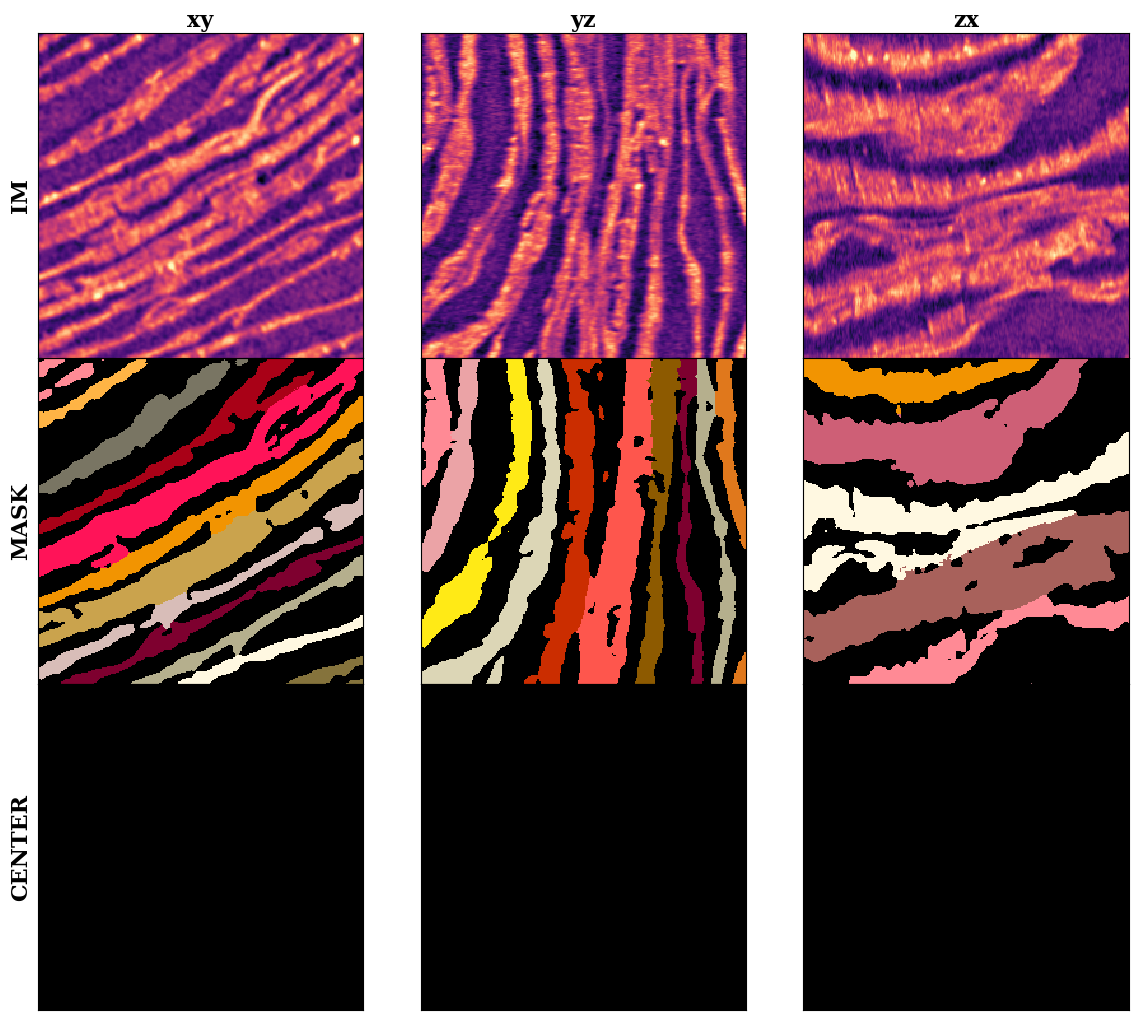

In [29]:
new_cmap = np.load('../../../cmaps/cmap_60.npy')
new_cmap = ListedColormap(new_cmap) # new_cmap = 'magma' would also work! 
visualize_crop_3d(data_dir=crops_dir, project_name=project_name, train_val_dir='val', center=center, 
                  new_cmp=new_cmap, anisotropy=anisotropy_factor)

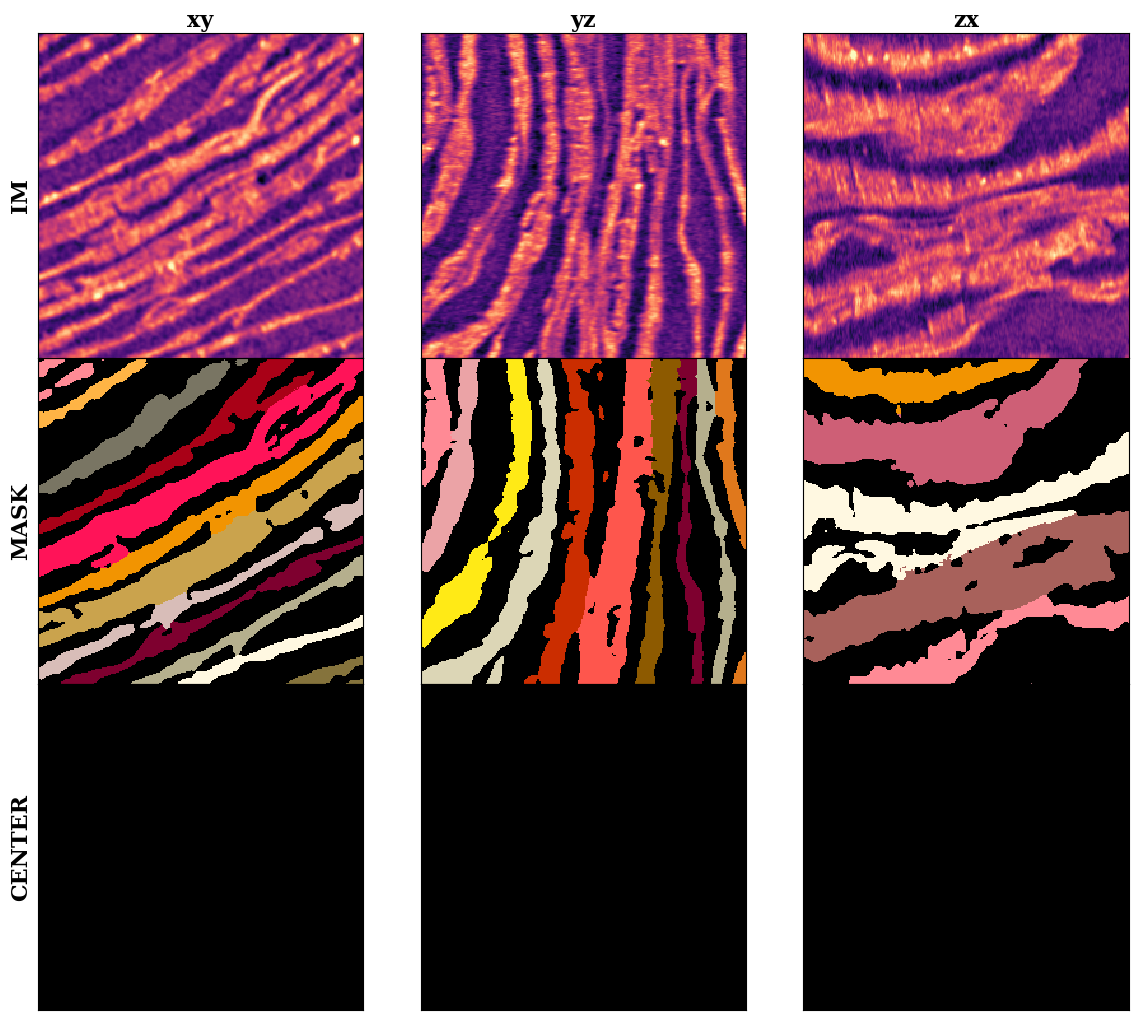

In [30]:
new_cmap = np.load('../../../cmaps/cmap_60.npy')
new_cmap = ListedColormap(new_cmap) # new_cmap = 'magma' would also work! 
visualize_crop_3d(data_dir=crops_dir, project_name=project_name, train_val_dir='train', center=center, 
                  new_cmp=new_cmap, anisotropy=anisotropy_factor)